In [388]:
import pandas as pd
import pandas_ta as ta

In [389]:
# getting the local datasets
df_aapl_intraday = pd.read_csv('data_aapl_intraday.csv', index_col=0, parse_dates=True) # to set the index as datetimeindex and not rangeindex
df_nflx_intraday = pd.read_csv('data_nflx_intraday.csv', index_col=0, parse_dates=True) # will be our working df
df_tsla_intraday = pd.read_csv('data_tsla_intraday.csv', index_col=0, parse_dates=True)


In [390]:
df = df_nflx_intraday.copy() # working df


In [391]:
df.head()

,Open,High,Low,Close,Volume
date,,,,,
2023-07-27 04:00:00,423.01,425.61,423.01,425.00,1150.0
2023-07-27 04:01:00,425.43,427.26,425.00,427.26,677.0
2023-07-27 04:02:00,427.19,427.19,426.00,426.70,341.0
2023-07-27 04:03:00,426.76,427.01,426.65,426.84,140.0
2023-07-27 04:04:00,426.84,427.64,426.84,427.49,117.0


In [ ]:
ind_list = df.ta.indicators(as_list=True)

In [ ]:
ind_list

Getting indicators out of the OHCL data

In [392]:
df['obv'] = ta.obv(df['Close'], df['Volume']) # On-Balance Volume
df['ad'] = ta.ad(df['High'], df['Low'], df['Close'], df['Volume']) # Accumulation/Distribution Line
adx = ta.adx(df['High'], df['Low'], df['Close']) # Average Directional Index
#print(adx)
df[['adx', 'dmp', 'dmn']] = adx[['ADX_14', 'DMP_14', 'DMN_14']]
macd = ta.macd(df['Close'], fast=2, slow=10) # MACD
#print(macd)
df[['macd', 'macdhist', 'macdsignal']] = macd[['MACD_2_10_9', 'MACDh_2_10_9', 'MACDs_2_10_9']]
df['rsi'] = ta.rsi(df['Close'], length=30) # Relative Strength Index (length 30 because I'm interested in the last half hour of data)
stoch = ta.stoch(df['High'], df['Low'], df['Close'], length=14)
#print(stoch)
df[['stochk', 'stochd']] = stoch[['STOCHk_14_3_3', 'STOCHd_14_3_3']]
bbands = ta.bbands(df['Close'], length=10, mamode="ema") #  Returns: pd.DataFrame: lower, mid, upper, bandwidth, and percent columns.
df[['bbandsl', 'bbandsm', 'bbandsu','bbandsb', 'bbandsp']] = bbands[['BBL_10_2.0', 'BBM_10_2.0', 'BBU_10_2.0', 'BBB_10_2.0', 'BBP_10_2.0']]



In [394]:
df.tail()
df.columns = df.columns.str.lower()

Now I put up together a strategy for one indicator and then I will expand this in a function so that we can apply it to all (or most) of the indicators.

In [556]:
import numpy as np

def get_signals_rsi(adf):
    # eg for the rsi we return a df where we 
    df = adf.copy()
    df['buy_signal'] = df['rsi'] < 40
    df['sell_signal'] = df['rsi'] > 60
    return df[['close', 'rsi', 'buy_signal', 'sell_signal']]
    

def get_signals_GC(adf):
    # eg for the rsi we return a df where we 
    df = adf.copy()
    df['buy_signal'] = df.ta.ema(5) > df.ta.ema(15)
    df['sell_signal'] = df.ta.ema(5) < df.ta.ema(15)
    return df[['close', 'buy_signal', 'sell_signal']]
    

In [493]:
newdf = df[(df.index.year == 2023)& ( df.index.month == 8) & ( df.index.day == 21)] # a temporary df of one day (21 august)

In [494]:
newdf.tail()

,open,high,low,close,volume,obv,ad,adx,dmp,dmn,...,rsi,stochk,stochd,bbandsl,bbandsm,bbandsu,bbandsb,bbandsp,buy_signal,sell_signal
date,,,,,,,,,,,,,,,,,,,,,
2023-08-21 19:55:00,407.00,407.00,406.33,406.33,56.0,-3648456.0,-2.178472e+06,18.815167,31.951057,17.685240,...,45.857476,9.100991,11.367095,406.188570,406.546493,406.904417,0.176080,0.197570,False,False
2023-08-21 19:56:00,406.40,406.40,406.40,406.40,40.0,-3648416.0,-2.178472e+06,19.524133,31.530249,17.452319,...,46.380629,5.086052,7.547143,406.193570,406.519858,406.846146,0.160528,0.316331,False,False
2023-08-21 19:57:00,406.50,406.88,406.50,406.88,11.0,-3648405.0,-2.178461e+06,21.025676,37.599232,15.905390,...,49.820066,27.540029,13.909024,406.176907,406.585339,406.993770,0.200908,0.860724,False,False
2023-08-21 19:58:00,406.88,406.88,406.50,406.50,10.0,-3648415.0,-2.178471e+06,22.419966,34.957524,14.787883,...,47.333501,34.509804,22.378628,406.187512,406.569822,406.952133,0.188066,0.408683,False,False
2023-08-21 19:59:00,406.70,407.00,406.50,406.50,155.0,-3648415.0,-2.178626e+06,23.909296,33.965388,13.448932,...,47.333501,38.431373,33.493735,406.175550,406.557127,406.938704,0.187711,0.425143,False,False


In [511]:
signalsdf = get_signals_rsi(newdf)

In [566]:
def get_trades(get_signals_df):
    trades = []
    current_trade = {'active': False}
    
    for index, row in get_signals_df.iterrows():
        close = row['close']
        rsi = row['rsi']
        buy_signal = row['buy_signal']
        sell_signal = row['sell_signal']
        if buy_signal and not current_trade['active']:
            current_trade = {'active': True, 'buy_date': index, 'buy_price': close, 'rsi_at_buy': rsi}

        elif sell_signal and current_trade['active']:
            current_trade['sell_date'] = index
            current_trade['sell_price'] = close
            current_trade['rsi_at_sell'] = rsi
            current_trade['profit'] = close - current_trade['buy_price'] 
            trades.append(current_trade)
            current_trade = {'active': False}
    
    return pd.DataFrame(trades)

def get_trades_GC(get_signals_df):
    trades = []
    current_trade = {'active': False}
    
    for index, row in get_signals_df.iterrows():
        close = row['close']
        buy_signal = row['buy_signal']
        sell_signal = row['sell_signal']
        if buy_signal and not current_trade['active']:
            current_trade = {'active': True, 'buy_date': index, 'buy_price': close, }

        elif sell_signal and current_trade['active']:
            current_trade['sell_date'] = index
            current_trade['sell_price'] = close
            current_trade['profit'] = close - current_trade['buy_price'] 
            trades.append(current_trade)
            current_trade = {'active': False}
    
    return pd.DataFrame(trades)
    
def calc_profit(df):

    total_profit = df['profit'].sum()
    print("Total Profit:", total_profit)

In [567]:
signalsdf.tail()

,close,rsi,buy_signal,sell_signal
date,,,,
2023-08-21 19:55:00,406.33,45.857476,False,False
2023-08-21 19:56:00,406.40,46.380629,False,False
2023-08-21 19:57:00,406.88,49.820066,False,False
2023-08-21 19:58:00,406.50,47.333501,False,False
2023-08-21 19:59:00,406.50,47.333501,False,False


In [568]:
tradesdf = get_trades(signalsdf)

In [580]:
tradesdf.head()

,active,buy_date,buy_price,rsi_at_buy,sell_date,sell_price,rsi_at_sell,profit
0,True,2023-08-21 08:01:00,402.64,25.025194,2023-08-21 12:16:00,403.3,60.035784,0.66


In [570]:
calc_profit(tradesdf)

Total Profit: 0.660000000000025


In [590]:
#help(ta.xsignals)

In [581]:
calc_profit(get_trades_GC(get_signals_GC(newdf)))

Total Profit: -9.294999999999959


In [598]:
# boilinger bands 
import matplotlib.pyplot as plt
bbdf = newdf.copy()

In [603]:
bbdf.head() # use bbandsl bbandsm bbandsu bbandsb bbandsp
# aka LOW MID UP

,open,high,low,close,volume,obv,ad,adx,dmp,dmn,...,rsi,stochk,stochd,bbandsl,bbandsm,bbandsu,bbandsb,bbandsp,buy_signal,sell_signal
date,,,,,,,,,,,,,,,,,,,,,
2023-08-21 04:00:00,404.60,405.47,404.50,405.47,165.0,-2595858.0,-1.175616e+06,15.752876,47.792103,21.352989,...,59.533742,96.581197,77.350427,403.887898,404.699194,405.510489,0.400938,0.975046,False,False
2023-08-21 04:01:00,405.03,405.64,405.03,405.64,136.0,-2595722.0,-1.175480e+06,17.589663,45.392323,18.780995,...,60.668727,100.000000,93.660969,403.877713,404.870249,405.862786,0.490299,0.887769,False,False
2023-08-21 04:02:00,406.26,406.29,406.00,406.18,210.0,-2595512.0,-1.175429e+06,20.036179,52.023734,16.500281,...,63.987785,98.391813,98.324336,403.803898,405.108386,406.412874,0.644019,0.910741,False,False
2023-08-21 04:03:00,405.68,405.68,405.68,405.68,21.0,-2595533.0,-1.175429e+06,21.376426,47.268564,20.841938,...,59.202412,89.473684,95.955166,403.874308,405.212316,406.550323,0.660398,0.674769,False,False
2023-08-21 04:04:00,405.72,405.72,405.64,405.72,148.0,-2595385.0,-1.175281e+06,22.620941,46.535647,20.518776,...,59.453362,81.140351,89.668616,404.028719,405.304622,406.580525,0.629602,0.662778,False,False


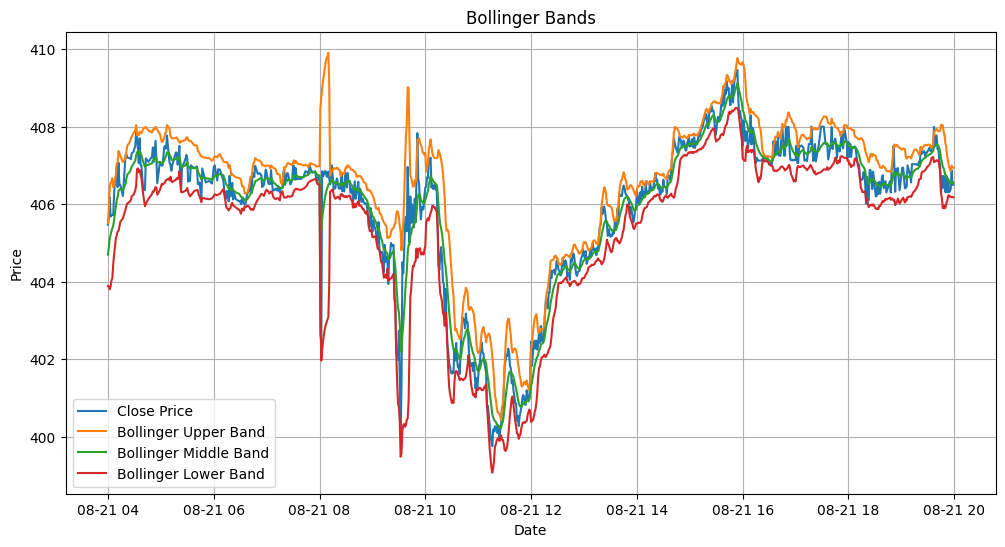

In [608]:
# Plot the data and Bollinger Bands
plt.figure(figsize=(12, 6))
plt.plot(bbdf.index, bbdf['close'], label='Close Price')
plt.plot(bbdf.index, bbdf['bbandsu'], label='Bollinger Upper Band', linestyle='solid')
plt.plot(bbdf.index, bbdf['bbandsm'], label='Bollinger Middle Band', linestyle='solid')
plt.plot(bbdf.index, bbdf['bbandsl'], label='Bollinger Lower Band', linestyle='solid')

plt.title('Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

model 1: linear regression 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model

# prep df
X = np.c_[df["rsi"]]
y = np.c_[df["close"]]


In [ ]:
# visualize data
df.plot(kind='scatter', x='rsi', y='close')
plt.show()

In [ ]:
# choose model
model = sklearn.linear_model.LinearRegression()


In [ ]:
# train model
model.fit(X,y)

In [ ]:
# make prediction
X_new = [[34]] # random rsi of 99
print(model.predict(X_new))

model 2: KNN 

In [ ]:
import sklearn.neighbors
model2 = sklearn.neighbors.KNeighborsRegressor(n_neighbors=3)


In [ ]:
model2.fit(X,y)

In [ ]:
# make prediction
X_new = [[34]] # random rsi of 99
print(model.predict(X_new))

In [ ]:
df.hist(bins=50, figsize=(20,15))
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
test_set

In [ ]:
temp = train_set.copy()

In [ ]:
temp.plot(kind='scatter', x='rsi', y='close', alpha=0.05)

In [ ]:
temp['sma2'] = temp.ta.sma(2)
temp['sma6'] = temp.ta.sma(6)
temp['logreturn'] = temp.ta.log_return()

In [ ]:
temp.head()

In [ ]:
temp.head()

Looking for correlations: two ways

In [ ]:
correlation_matrix = temp.corr()

In [ ]:
correlation_matrix["close"].sort_values(ascending=False)
# here we can see the correlation between the close price and the other features
# this could help us in deciding which columns to keep
# value between -1 and 1


In [ ]:
from pandas.plotting import scatter_matrix
attributes = ["close", "sma2", "rsi",
 "logreturn"]
scatter_matrix(temp[attributes], figsize=(12, 8))

Prepare the data for ML algorithms

1 Clean the data

In [ ]:
from sklearn.preprocessing import StandardScaler

SELECT AND TRAIN A MODEL

1 TRAINING AND EVALUATING ON THE TRAINING SET

In [ ]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
X = train_set.copy()
y = np.c_[train_set["close"]]
lin_reg.fit(X, y)
some_X = X[:5]
some_y = y[:5]


In [ ]:
def print_preds(model, someX, somey):
    for i in range(len(someX)):
        print('Prediction: ' , model.predict(someX[[i]]))
        print('Actual value: ', somey[i][0], '\n')    

In [ ]:
print_preds(lin_reg, some_X, some_y)

In [ ]:
# we measure the RMSE on the whole training set
# this RMSE is the score on the training set
from sklearn.metrics import mean_squared_error
def print_rmse(model, X, y):
    preds = model.predict(X)
    rmse = mean_squared_error(y, preds)
    rmse = np.sqrt(rmse)
    print(rmse)
print_rmse(lin_reg, X, y)


Now we calculate the RMSE with another model

In [ ]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X, y)

In [ ]:
print_rmse(tree_reg, X, y)

This looks much better but its only on the training data so most likely its been too overfitted.

Next we do K-fold cross validation ** insert some reasonings here **


In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, X, y, scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [ ]:
# these are the RMSE scores on the validation sets
def display_scores(scores):
    print('Scores: ', scores)
    print('Mean: ', scores.mean())
    print('Standard deviation: ', scores.std())

In [ ]:
display_scores(tree_rmse_scores)

Now we can see how the performance of thre decision tree regressing model is actually worse than just a normal linear regression, this information we obtained by performing cross validation.
The bad part is that this is really costly as we train the model a lot of times and not just once.
But the good part is that we can find that the model isnt actually good before we continue with it for further testing it and deploying it. It gives us a clear indiciation of its performance at the training stage.

In [ ]:
lin_scores = cross_val_score(lin_reg, X, y, scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

In [ ]:
display_scores(lin_rmse_scores)

Conclusion: if the RMSE on the training data is much less than the mean RMSE on the validaiton sets, then that means that we still have the issue that the model is overfitting on the training data.

8 Finetuning the models with 1. GridSearch

In [ ]:
# Using GridSearch we can automate the process to find the best combination of hyperparameters.
from sklearn.model_selection import GridSearchCV


#for example here we will use the GridSearch for the lin_reg model we created earlier
# write later when internet

2 With Randomized Search

3 With Ensemble Methods: here we combine the models that peform the best by grouping them. The performance is usually beter than individual models. 

With gridsearch we can not only find the best combination of parameters, but we can also see the relative importance of each feature in predicting the desired value. ** check again page 82 **

Evaluate the model on the Test set

In [ ]:
# final model = grid_search.best_estimator_
# X_test = test_set.drop("close", axis=1)
# y_test = test_set["close"].copy()
# final_predictions = final_model.predict(X_test)
# final_mse = mean_squared_error(y_test, final_predictions)
# final_rmse = np.sqrt(final_mse)

CLASSIFICATION **read pages 94 **

In [ ]:
from sklearn.model_selection import cross_val_predict
# y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

TRAINING MODELS CHAPTER 4 (we will train the lin reg again but in two different approaches)
1 = like we did earlier, just train it and make sure to minimize the cost function (alrdy trained)
2 = Gradient Descent; gradually improving the model by doing it iteratively (will train in GD)

Training a model means setting the parameters in a way that allows the model to best fit the training set. Most common way to do this is by the RMSE. 
** GD BELOW **

In [ ]:
# Gradient Descent finds the best parameters iteratively in order to minimize the cost function
# Important to use StandardScaler on the features when using GD
# Most important param of GD is the learning_rate (use GridSearch to find it !)
# A learning rate too low will take too long to find the global minimum
# A learning rate too high on the other hand will jump around too much and perhaps miss the global minimum

There is batch GD but that one requires a lot of iterations before it finds the global minima. On the other hand there is also stochastic GD which is much faster (which is preferred when the dataset has a lot of values) but due to its randomness it will not find the optimal parameters, but really close to them. Another benefit is that it has a better chance of finding the global minimum than batch GD since it can escape the global minima better. The idea behind the stochastic GD is that it starts with a random learning rate and then slowly decreases it.


In [ ]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())

In [ ]:
sgd_reg.coef_


Using logistic regression as a binary classifier

In [ ]:
from sklearn.linear_model import LogisticRegression
import pandas_ta as ta
log_reg = LogisticRegression()
# we do it without train test first
# !!! we use single feature close to predict
# the roc 
X_new = df.copy()
X_new.ta.roc( 2, append=True)
X_new.dropna(inplace=True)
X_single_feature = np.c_[X_new["close"]]
X_new['price_increased'] = np.where(X_new['ROC_2'] > 0, 1, 0)

y_new = np.c_[X_new["price_increased"]]


In [ ]:
X_new[900000:900010]

In [ ]:
X_single_feature.shape

In [ ]:
y_new.shape

In [ ]:
X_single_feature

In [ ]:
y_new

In [ ]:
log_reg.fit(X_single_feature, y_new)

In [ ]:
print_rmse(log_reg, X_single_feature, y_new)

In [ ]:
# we do it without train test first
# !!! we use multiple features to predict
# the roc 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

log_reg = LogisticRegression()

X_new = df.copy()
X_new.ta.roc( 2, append=True)
X_new.dropna(inplace=True)
X_new['price_increased'] = np.where(X_new['ROC_2'] > 0, 1, 0)



In [ ]:


# Split the data into features (X) and target variable (y)
X = X_new[['close', 'rsi']]
y = X_new['price_increased']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the logistic regression model
model = LogisticRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
predictions = model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)


DECISION TREES

In [ ]:
df = df.ta.ticker("aapl")

df = df[10500:10600]



In [ ]:
df.info()

In [ ]:
df.head()

In [ ]:
df.ta.strategy("Momentum") # Default values for all Momentum indicators


In [ ]:
df.columns

In [ ]:
cor_matrix = df.corr()

In [ ]:
cor_matrix["Close"].sort_values(ascending=False)


In [ ]:
doji = df.ta.cdl_pattern(name="haramicross")


In [ ]:
doji.value_counts()

In [ ]:
# Convert the DataFrame to the format required by mplfinance
ohlc = df[['Open', 'High', 'Low', 'Close']]
ohlc.index.name = 'Date'
import mplfinance as mpf

# Create an array for marker style based on the doji pattern signal

# Plot the candlestick chart with the Doji pattern markers
mpf.plot(
    ohlc, 
    type='candle', 
    style='charles', 
    title='Candlestick Chart with Doji Pattern',
    addplot=[
        mpf.make_addplot(doji, panel=1, color='g', secondary_y=False)    ]
)